# Exercises

In [2]:
import numpy as np
import scipy
import scipy.stats
import scipy.io
import matplotlib.pyplot as plt
from ipywidgets import interact
import ipywidgets as widgets
from tqdm import tqdm
import seaborn as sns
import pickle
import sys
import os
sys.path.append(os.path.abspath("code"))
from utils import download_data

sns.set_theme(context='notebook',style='white',font_scale=1.5,
              rc = {'axes.spines.top':False,'axes.spines.right':False})

In [3]:
# Download lesson data
download_data('https://surfdrive.surf.nl/files/index.php/s/FeDX3LfbJ4pC7T6')

## Exercise 1 - simulating place cells
---
Use the code we build to simulate place cells in the lesson.

A - Explore what happens when you change the binning in the definition of the firing rate maps (`space_bins`). Make it coarser or broader. 


B - In the spike train simulations, we add some "baseline" noise, not place-related to the firing. Which variable determines the noise level? Try to experiment with that variable and see what happens to the firing rate maps. What is the best approach to firing rate maps when the noise is high.


C - We could use other approaches to firing rate maps: for example make the binning very small (down to 1 cm, which is the resolution of our "video" data, and then applying a gaussian smoother. Scipy has a Gaussian smoother at `scipy.stats.gaussian_kde`. Read the documentation for that function and apply it to the data to define the smoothed firing rate maps. Again, change the noise levels and see how the smoother changes. 

D - When analyzing place fields, two important quantities are the place field center and the place field width. The place field center may be defined in many ways, but one is to compute the "center of mass" of the spikes according to the equation 

$$ c_{pf} = \frac{1}{N_{spikes}} \sum_{i} L_i $$ 

where the sum on $i$ runs on all spikes emitted by a cell and $L_i$ is the location at which the i-th spike was emitted. Calculate this for each cell. Compare with the "true" place field centers from the simulations (which variables are we talking about?) 


In [4]:
track_length = 200. # the length of our linear track (eg in centimeter)
average_firing_rate = 5 # the peak firing rate, averaged across the population 
n_cells = 100 # how many cells we are recording
pf_centers = np.random.rand(n_cells) * track_length # the centers of the place fields for all cells drawn randomly with a uniform distribution on the track
pf_size = np.random.gamma(10, size=n_cells) # the size (width) of the place fields, drawn randomly from a gamma distribution 
pf_rate = np.random.exponential(scale=average_firing_rate, size=n_cells) # the peak firing rate for each cell, drawn from an exponential distribution

Text(0, 0.5, 'Probability')

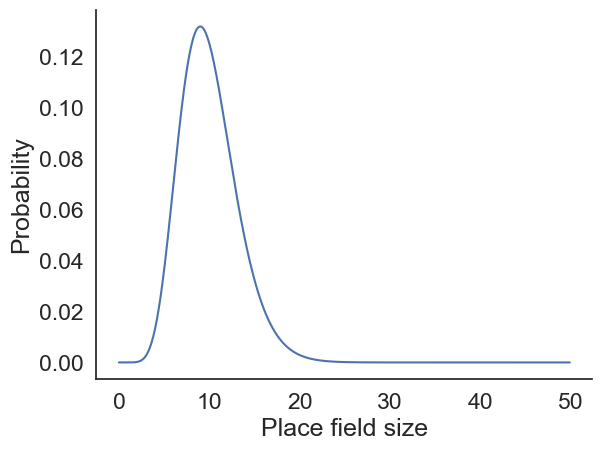

In [5]:
x = np.arange(0., 50., 0.1) # we use a grid with step 0.1
g = scipy.stats.gamma.pdf(x, 10)
plt.plot(x, g)
plt.xlabel('Place field size')
plt.ylabel('Probability')

In [6]:
bins = np.arange(0., 200.)
true_firing_rate_maps = np.zeros((n_cells, len(bins)))
for i in range(n_cells):
    true_firing_rate_maps[i,:] = pf_rate[i] * np.exp(-((bins-pf_centers[i])**2)/(2*pf_size[i]**2))

In [9]:
n_runs = 20 
av_running_speed = 10 # the average running speed (in cm/s)
fps = 30 # the number of "video frames" per second 
running_speed_a = np.random.chisquare(10, size=n_runs) # running speed in the two directions
running_speed_b = np.random.chisquare(10, size=n_runs) 

stopping_time_a = np.random.chisquare(15, size=n_runs) # the time the mouse will spend at the two ends of the track
stopping_time_b = np.random.chisquare(15, size=n_runs)

x = np.array([])
for i in range(n_runs):
    stop1 = np.ones((int(stopping_time_a[i]*fps),)) * 0.
    run_length = len(bins) * fps / running_speed_a[i]
    run1 = np.linspace(0., float(len(bins)-1), int(run_length))
    stop2 = np.ones((int(stopping_time_b[i]*fps),)) * (len(bins)-1.)
    run_length = len(bins) * fps / running_speed_b[i]
    run2 = np.linspace(len(bins)-1., 0., int(run_length))
    x = np.concatenate((x, stop1, run1, stop2, run2))
t = np.arange(len(x))/fps

In [11]:
sampling_rate = 10000.
t_sampling = np.arange(0, t[-1], 1. / sampling_rate)
x_sampling = np.floor(np.interp(t_sampling, t, x))
noise_firing_rate = 0.1 # the baseline noise firing rate
spikes = []

for i in tqdm(range(n_cells)):
    inst_rate = true_firing_rate_maps[i,x_sampling.astype(np.int32)] + noise_firing_rate
    spikes_loc = np.random.poisson(inst_rate/sampling_rate)
    sp = np.argwhere(spikes_loc)
    t_sp = t_sampling[sp]
    spikes.append(t_sp)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:13<00:00,  1.36it/s]


In [13]:
spike_positions = [np.interp(s, t, x) for s in spikes]

### A 
- Explore what happens when you change the binning in the definition of the firing rate maps (space_bins). Make it coarser or broader.

##### Coarser binning

In [23]:
space_bins = np.arange(0., 200., 20.)

# we compute histograms for eaxh cell
spikes_hist= [np.histogram(s, space_bins)[0] for s in spike_positions]

# put them together into a matrix of floating point numbers (for plotting)
spikes_hist = np.vstack(spikes_hist).astype(np.float64)

# we also need an "occupancy histogram" in order to normalize the firing rates maps 
occupancy = np.histogram(x, space_bins)[0] /  fps

firing_rate_maps = spikes_hist / occupancy 

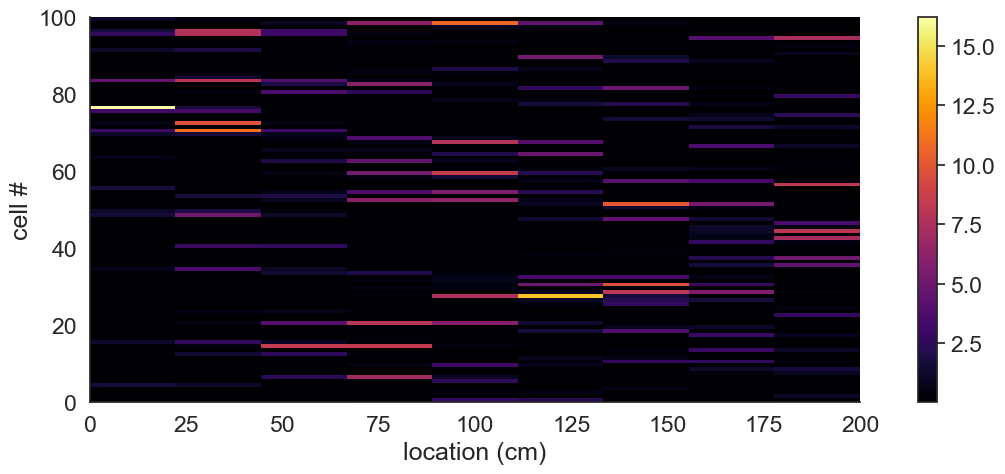

In [24]:
plt.figure(figsize=(15,5))
plt.imshow(firing_rate_maps, cmap='inferno', extent = [0, 200, 0, n_cells])
plt.xlabel('location (cm)')
plt.ylabel('cell #')
plt.colorbar()

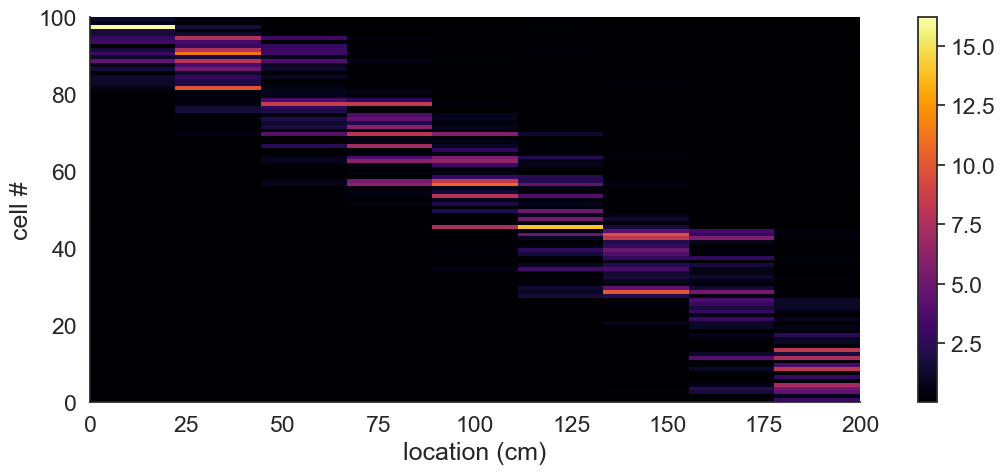

In [25]:
plt.figure(figsize=(15,5))
peak_locations = firing_rate_maps.argmax(axis=1)
ix = np.argsort(peak_locations)
plt.imshow(firing_rate_maps[ix,:], cmap='inferno', extent = [0, 200, 0, n_cells])
plt.xlabel('location (cm)')
plt.ylabel('cell #')
plt.colorbar()

- Coarser Binning: Larger bin sizes will result in fewer bins along the x-axis. This means each bin will contain more data points, potentially smoothing out the firing rate maps and making broad patterns more apparent but less detailed.

##### Broader binning

In [26]:
space_bins = np.arange(0., 200., 10.)

# we compute histograms for eaxh cell
spikes_hist= [np.histogram(s, space_bins)[0] for s in spike_positions]

# put them together into a matrix of floating point numbers (for plotting)
spikes_hist = np.vstack(spikes_hist).astype(np.float64)

# we also need an "occupancy histogram" in order to normalize the firing rates maps 
occupancy = np.histogram(x, space_bins)[0] /  fps

firing_rate_maps = spikes_hist / occupancy 

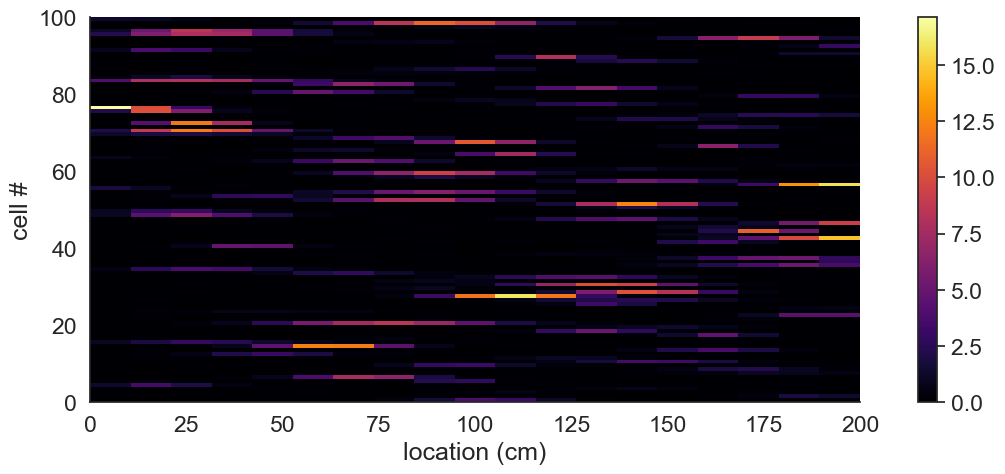

In [27]:
plt.figure(figsize=(15,5))
plt.imshow(firing_rate_maps, cmap='inferno', extent = [0, 200, 0, n_cells])
plt.xlabel('location (cm)')
plt.ylabel('cell #')
plt.colorbar()

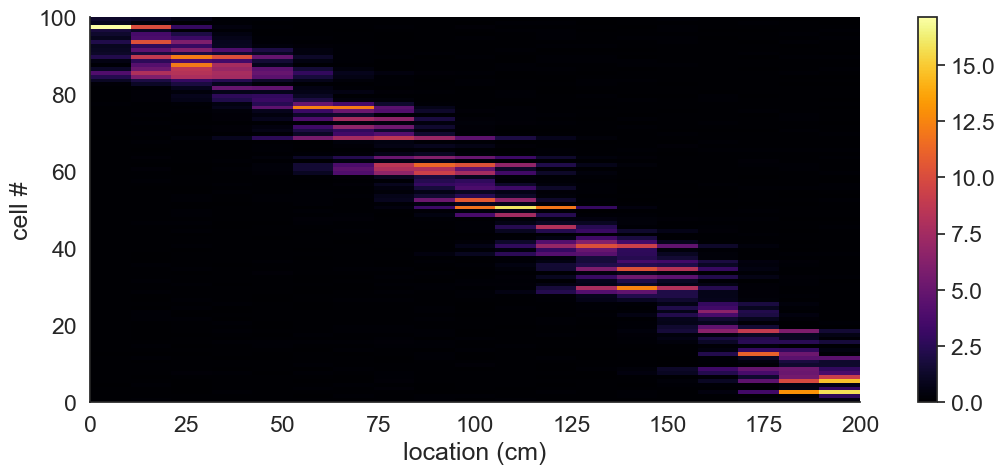

In [28]:
plt.figure(figsize=(15,5))
peak_locations = firing_rate_maps.argmax(axis=1)
ix = np.argsort(peak_locations)
plt.imshow(firing_rate_maps[ix,:], cmap='inferno', extent = [0, 200, 0, n_cells])
plt.xlabel('location (cm)')
plt.ylabel('cell #')
plt.colorbar()

- Broader Binning: Extends the range of the bins (e.g., up to 250 cm). This covers a broader range of data, which might reveal patterns over a larger space if the data extends beyond the original 200 cm range.

### B 
- In the spike train simulations, we add some "baseline" noise, not place-related to the firing. Which variable determines the noise level? Try to experiment with that variable and see what happens to the firing rate maps. What is the best approach to firing rate maps when the noise is high.

##### Low Noise (e.g., 0.1):
With low noise, the firing rate maps should clearly show place fields with minimal background activity.

In [29]:
sampling_rate = 10000.
t_sampling = np.arange(0, t[-1], 1. / sampling_rate)
x_sampling = np.floor(np.interp(t_sampling, t, x))
noise_firing_rate = 0.1 # the baseline noise firing rate
spikes = []

for i in tqdm(range(n_cells)):
    inst_rate = true_firing_rate_maps[i,x_sampling.astype(np.int32)] + noise_firing_rate
    spikes_loc = np.random.poisson(inst_rate/sampling_rate)
    sp = np.argwhere(spikes_loc)
    t_sp = t_sampling[sp]
    spikes.append(t_sp)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:15<00:00,  1.33it/s]


In [30]:
def plot_unit(i):
    plt.figure(figsize=(10,5))
    plt.plot(t, x)
    plt.plot(spikes[i], np.interp(spikes[i], t, x), 'r.')
    plt.xlabel('Time (s)')
    plt.ylabel('position on track (cm)')
    
interact(plot_unit, i = widgets.IntSlider(min=0, max=(n_cells-1), value=0))

interactive(children=(IntSlider(value=0, description='i', max=99), Output()), _dom_classes=('widget-interact',…

<function __main__.plot_unit(i)>

In [31]:
spike_positions = [np.interp(s, t, x) for s in spikes]

In [32]:
space_bins = np.arange(0., 200., 5.)

# we compute histograms for eaxh cell
spikes_hist= [np.histogram(s, space_bins)[0] for s in spike_positions]

# put them together into a matrix of floating point numbers (for plotting)
spikes_hist = np.vstack(spikes_hist).astype(np.float64)

# we also need an "occupancy histogram" in order to normalize the firing rates maps 
occupancy = np.histogram(x, space_bins)[0] /  fps

firing_rate_maps = spikes_hist / occupancy 

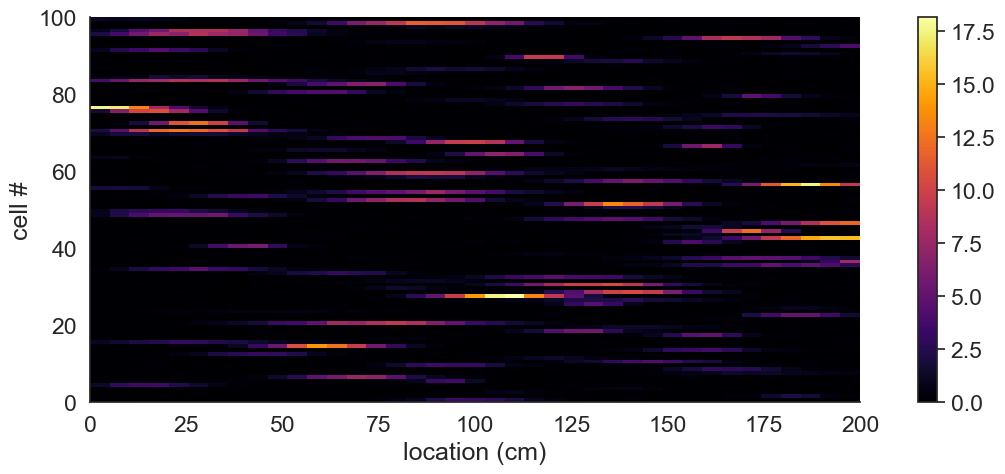

In [33]:
plt.figure(figsize=(15,5))
plt.imshow(firing_rate_maps, cmap='inferno', extent = [0, 200, 0, n_cells])
plt.xlabel('location (cm)')
plt.ylabel('cell #')
plt.colorbar()

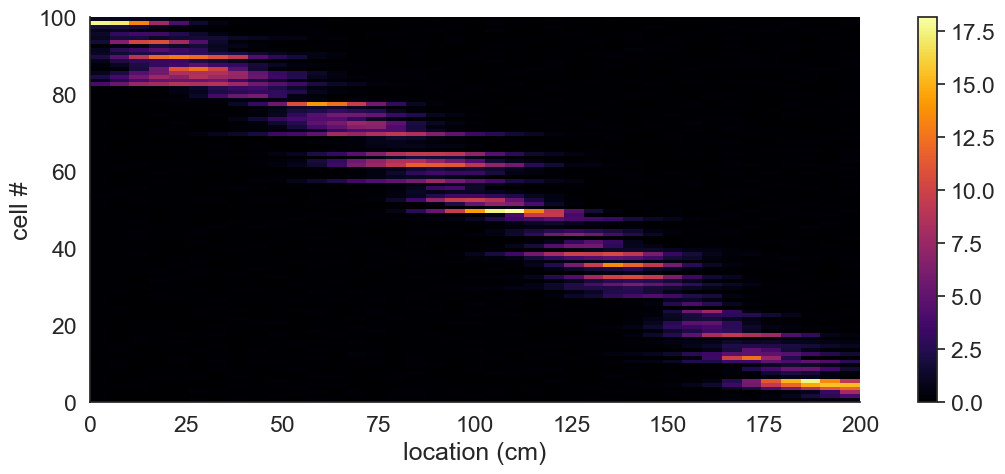

In [34]:
plt.figure(figsize=(15,5))
peak_locations = firing_rate_maps.argmax(axis=1)
ix = np.argsort(peak_locations)
plt.imshow(firing_rate_maps[ix,:], cmap='inferno', extent = [0, 200, 0, n_cells])
plt.xlabel('location (cm)')
plt.ylabel('cell #')
plt.colorbar()

##### Medium Noise (e.g., 0.5): 
As the noise level increases, the place fields may still be visible, but there will be more background firing, making the maps noisier.

In [35]:
sampling_rate = 10000.
t_sampling = np.arange(0, t[-1], 1. / sampling_rate)
x_sampling = np.floor(np.interp(t_sampling, t, x))
noise_firing_rate = 0.5 # the baseline noise firing rate
spikes = []

for i in tqdm(range(n_cells)):
    inst_rate = true_firing_rate_maps[i,x_sampling.astype(np.int32)] + noise_firing_rate
    spikes_loc = np.random.poisson(inst_rate/sampling_rate)
    sp = np.argwhere(spikes_loc)
    t_sp = t_sampling[sp]
    spikes.append(t_sp)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:15<00:00,  1.32it/s]


In [36]:
def plot_unit(i):
    plt.figure(figsize=(10,5))
    plt.plot(t, x)
    plt.plot(spikes[i], np.interp(spikes[i], t, x), 'r.')
    plt.xlabel('Time (s)')
    plt.ylabel('position on track (cm)')
    
interact(plot_unit, i = widgets.IntSlider(min=0, max=(n_cells-1), value=0))

interactive(children=(IntSlider(value=0, description='i', max=99), Output()), _dom_classes=('widget-interact',…

<function __main__.plot_unit(i)>

In [37]:
spike_positions = [np.interp(s, t, x) for s in spikes]

In [38]:
space_bins = np.arange(0., 200., 5.)

# we compute histograms for eaxh cell
spikes_hist= [np.histogram(s, space_bins)[0] for s in spike_positions]

# put them together into a matrix of floating point numbers (for plotting)
spikes_hist = np.vstack(spikes_hist).astype(np.float64)

# we also need an "occupancy histogram" in order to normalize the firing rates maps 
occupancy = np.histogram(x, space_bins)[0] /  fps

firing_rate_maps = spikes_hist / occupancy 

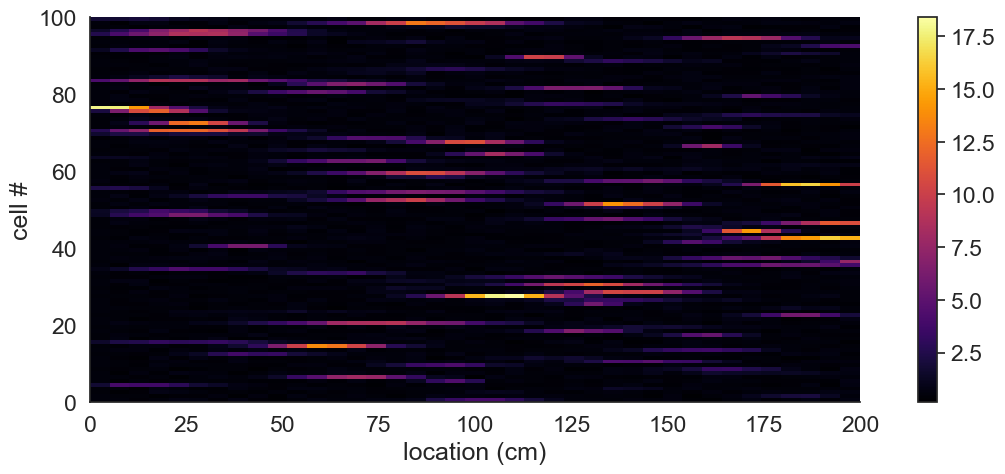

In [39]:
plt.figure(figsize=(15,5))
plt.imshow(firing_rate_maps, cmap='inferno', extent = [0, 200, 0, n_cells])
plt.xlabel('location (cm)')
plt.ylabel('cell #')
plt.colorbar()

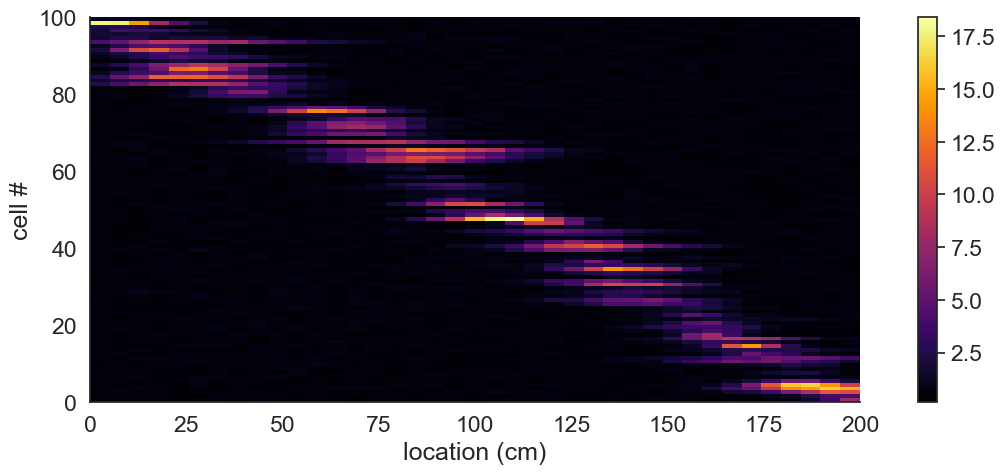

In [40]:
plt.figure(figsize=(15,5))
peak_locations = firing_rate_maps.argmax(axis=1)
ix = np.argsort(peak_locations)
plt.imshow(firing_rate_maps[ix,:], cmap='inferno', extent = [0, 200, 0, n_cells])
plt.xlabel('location (cm)')
plt.ylabel('cell #')
plt.colorbar()

##### High Noise (e.g., 1.0): 
At high noise levels, place fields can become obscured by high background firing, making it harder to distinguish real place-related firing.

In [41]:
sampling_rate = 10000.
t_sampling = np.arange(0, t[-1], 1. / sampling_rate)
x_sampling = np.floor(np.interp(t_sampling, t, x))
noise_firing_rate = 1.0 # the baseline noise firing rate
spikes = []

for i in tqdm(range(n_cells)):
    inst_rate = true_firing_rate_maps[i,x_sampling.astype(np.int32)] + noise_firing_rate
    spikes_loc = np.random.poisson(inst_rate/sampling_rate)
    sp = np.argwhere(spikes_loc)
    t_sp = t_sampling[sp]
    spikes.append(t_sp)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:17<00:00,  1.29it/s]


In [42]:
def plot_unit(i):
    plt.figure(figsize=(10,5))
    plt.plot(t, x)
    plt.plot(spikes[i], np.interp(spikes[i], t, x), 'r.')
    plt.xlabel('Time (s)')
    plt.ylabel('position on track (cm)')
    
interact(plot_unit, i = widgets.IntSlider(min=0, max=(n_cells-1), value=0))

interactive(children=(IntSlider(value=0, description='i', max=99), Output()), _dom_classes=('widget-interact',…

<function __main__.plot_unit(i)>

In [43]:
spike_positions = [np.interp(s, t, x) for s in spikes]

In [44]:
space_bins = np.arange(0., 200., 5.)

# we compute histograms for eaxh cell
spikes_hist= [np.histogram(s, space_bins)[0] for s in spike_positions]

# put them together into a matrix of floating point numbers (for plotting)
spikes_hist = np.vstack(spikes_hist).astype(np.float64)

# we also need an "occupancy histogram" in order to normalize the firing rates maps 
occupancy = np.histogram(x, space_bins)[0] /  fps

firing_rate_maps = spikes_hist / occupancy 

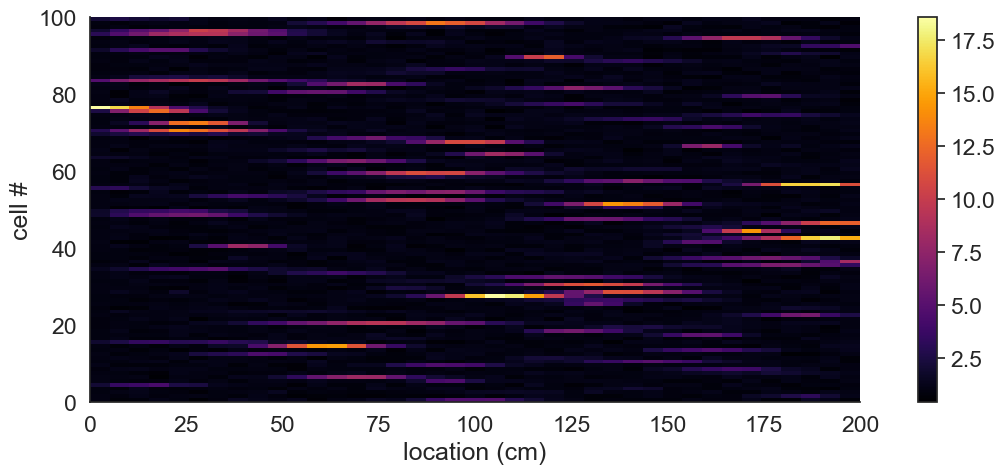

In [45]:
plt.figure(figsize=(15,5))
plt.imshow(firing_rate_maps, cmap='inferno', extent = [0, 200, 0, n_cells])
plt.xlabel('location (cm)')
plt.ylabel('cell #')
plt.colorbar()

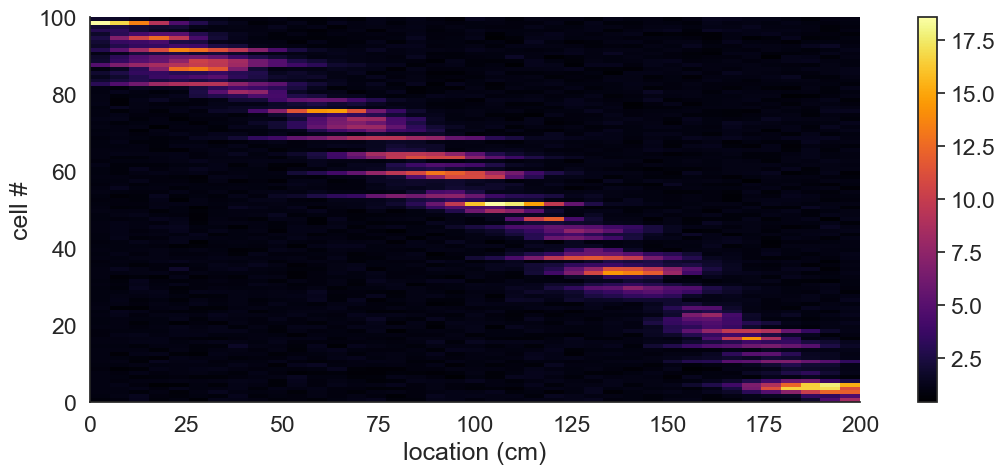

In [46]:
plt.figure(figsize=(15,5))
peak_locations = firing_rate_maps.argmax(axis=1)
ix = np.argsort(peak_locations)
plt.imshow(firing_rate_maps[ix,:], cmap='inferno', extent = [0, 200, 0, n_cells])
plt.xlabel('location (cm)')
plt.ylabel('cell #')
plt.colorbar()

### C 
- We could use other approaches to firing rate maps: for example make the binning very small (down to 1 cm, which is the resolution of our "video" data, and then applying a gaussian smoother. Scipy has a Gaussian smoother at scipy.stats.gaussian_kde. Read the documentation for that function and apply it to the data to define the smoothed firing rate maps. Again, change the noise levels and see how the smoother changes.

In [47]:
#IMPORTING NECESSARY LIBRARIES

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.stats import gaussian_kde
from ipywidgets import interact, widgets

# Assuming true_firing_rate_maps, t, x, and n_cells are already defined
sampling_rate = 10000.
t_sampling = np.arange(0, t[-1], 1. / sampling_rate)
x_sampling = np.floor(np.interp(t_sampling, t, x))

In [48]:
#DEFINING NECESSARY FUNCTIONS TO GENERATE SPIKES AND COMPUTE FIRING RATE MAPS

def generate_spikes(noise_firing_rate, true_firing_rate_maps, x_sampling, t_sampling, n_cells, sampling_rate):
    spikes = []
    for i in tqdm(range(n_cells)):
        inst_rate = true_firing_rate_maps[i, x_sampling.astype(np.int32)] + noise_firing_rate
        spikes_loc = np.random.poisson(inst_rate / sampling_rate)
        sp = np.argwhere(spikes_loc)
        t_sp = t_sampling[sp].flatten()
        spikes.append(t_sp)
    return spikes

def compute_firing_rate_maps(spike_positions, space_bins, t, x, n_cells, fps):
    spikes_hist = [np.histogram(s, space_bins)[0] for s in spike_positions]
    spikes_hist = np.vstack(spikes_hist).astype(np.float64)
    occupancy = np.histogram(x, space_bins)[0] / fps
    firing_rate_maps = spikes_hist / occupancy
    return firing_rate_maps

def plot_firing_rate_maps(firing_rate_maps, space_bins, title):
    plt.figure(figsize=(15, 5))
    plt.imshow(firing_rate_maps, cmap='inferno', extent=[space_bins[0], space_bins[-1], 0, firing_rate_maps.shape[0]])
    plt.xlabel('location (cm)')
    plt.ylabel('cell #')
    plt.colorbar()
    plt.title(title)
    plt.show()


In [49]:
#APPLYING GAUSSIAN SMOOTHING

def smooth_firing_rate_maps(firing_rate_maps):
    smoothed_maps = []
    for fr in firing_rate_maps:
        x = np.linspace(0, 200, len(fr))  # Assuming range of 200 cm
        kde = gaussian_kde(fr, bw_method='scott')
        smoothed_fr = kde(x)
        smoothed_maps.append(smoothed_fr)
    smoothed_maps = np.vstack(smoothed_maps)
    return smoothed_maps

In [60]:
# PLOT FIRING RATE MAPS
def plot_sorted_firing_rate_maps(firing_rate_maps, space_bins, n_cells, title):
    plt.figure(figsize=(15, 5))
    peak_locations = firing_rate_maps.argmax(axis=1)
    ix = np.argsort(peak_locations)
    plt.imshow(firing_rate_maps[ix, :], aspect='auto', cmap='inferno', extent=[space_bins[0], space_bins[-1], 0, n_cells])
    plt.xlabel('Location (cm)')
    plt.ylabel('Cell #')
    plt.colorbar(label='Firing Rate')
    plt.title(title)
    plt.show()

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:15<00:00,  1.32it/s]


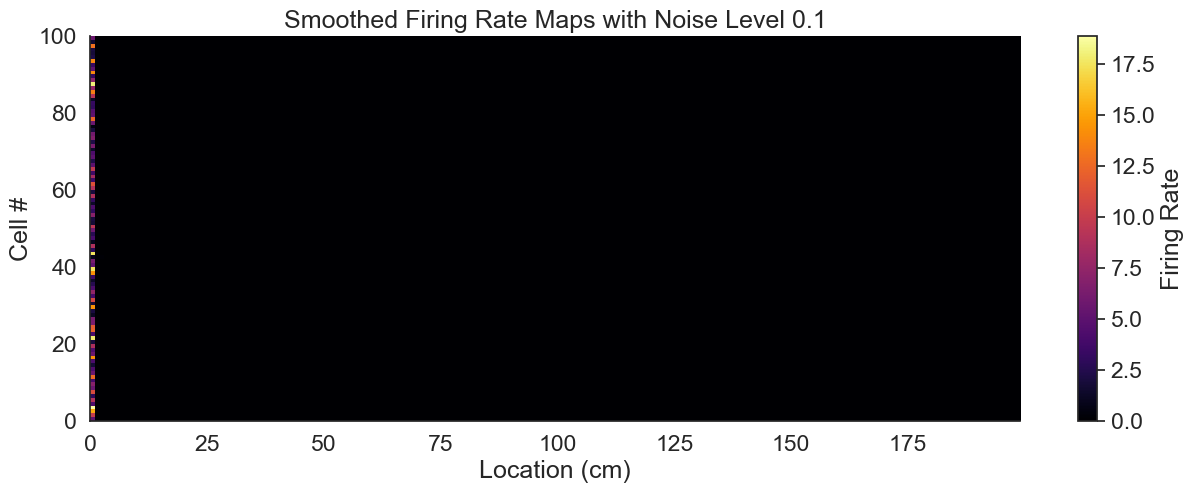

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:15<00:00,  1.32it/s]


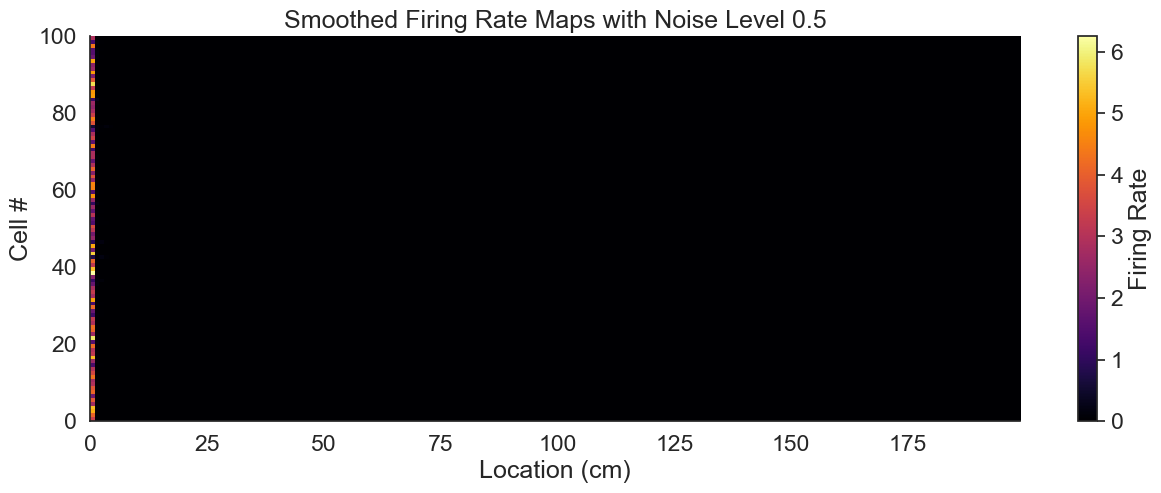

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:13<00:00,  1.36it/s]


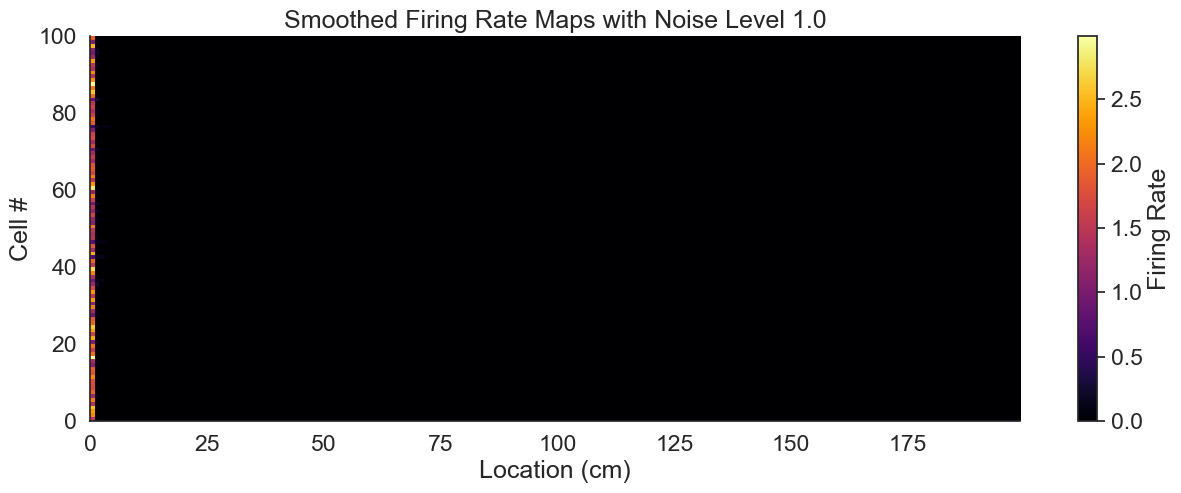

In [79]:
#EXPERIMENTING WITH DIFFERENT NOISE LEVELS

# Define space bins with 1 cm resolution
space_bins = np.arange(0., 200., 1.)

# Experiment with different noise levels
noise_levels = [0.1, 0.5, 1.0]  # Adjust these values as needed
fps = 30  # Assuming a frame rate of 30 fps

for noise_firing_rate in noise_levels:
    spikes = generate_spikes(noise_firing_rate, true_firing_rate_maps, x_sampling, t_sampling, n_cells, sampling_rate)
    firing_rate_maps = compute_firing_rate_maps(spikes, space_bins, t, x, n_cells, fps)
    smoothed_firing_rate_maps = smooth_firing_rate_maps(firing_rate_maps)
    plot_firing_rate_maps(smoothed_firing_rate_maps, space_bins, f'Smoothed Firing Rate Maps with Noise Level {noise_firing_rate}')

In [80]:
#PLOTTING INDIVIDUAL UNIT FOR INSPECTION

def plot_unit(i):
    plt.figure(figsize=(10, 5))
    plt.plot(t, x, label='Track position')
    plt.plot(spikes[i], np.interp(spikes[i], t, x), 'r.', label='Spikes')
    plt.xlabel('Time (s)')
    plt.ylabel('Position on track (cm)')
    plt.legend()
    plt.show()

### D 
- When analyzing place fields, two important quantities are the place field center and the place field width. The place field center may be defined in many ways, but one is to compute the "center of mass" of the spikes according to the equation $ c_{pf}=\frac{1}{N_{spikes}}\sum_i L_i $ where the sum on  𝑖 runs on all spikes emitted by a cell and  𝐿𝑖 is the location at which the i-th spike was emitted. Calculate this for each cell. Compare with the "true" place field centers from the simulations (which variables are we talking about?)

To calculate the place field center using the "center of mass" method, we need to follow these steps:

1. Calculate the place field center for each cell using the provided formula $ c_{pf}=\frac{1}{N_{spikes}}\sum_i L_i $.
2. Compare the calculated place field centers with the "true" place field centers from the simulations. The "true" place field centers are derived from the true_firing_rate_maps.

In [69]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.stats import gaussian_kde
from ipywidgets import interact, widgets

In [70]:
# ASSUMING true_firing_rate_maps, t, x, AND n_cells ARE ALREADY DEFINED
sampling_rate = 10000.
t_sampling = np.arange(0, t[-1], 1. / sampling_rate)
x_sampling = np.floor(np.interp(t_sampling, t, x))

In [71]:
# GENERATING SPIKES WITH A SPECIFIED NOISE LEVEL
noise_firing_rate = 0.1 
spikes = generate_spikes(noise_firing_rate, true_firing_rate_maps, x_sampling, t_sampling, n_cells, sampling_rate)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:18<00:00,  1.27it/s]


In [72]:
# CALCULATING PLACE FIELD CENTERS USING THE "CENTER OF MASS" METHOD
def calculate_place_field_centers(spikes, t, x):
    place_field_centers = []
    for sp in spikes:
        if len(sp) == 0:
            place_field_centers.append(np.nan)
        else:
            L_i = np.interp(sp, t, x)  
            c_pf = np.mean(L_i)  
            place_field_centers.append(c_pf)
    return np.array(place_field_centers)

calculated_centers = calculate_place_field_centers(spikes, t, x)

In [73]:
# CALCULATING "TRUE" PLACE FIELD CENTERS FROM true_firing_rate_maps
def calculate_true_place_field_centers(true_firing_rate_maps):
    true_centers = []
    for fr_map in true_firing_rate_maps:
        L_i = np.arange(fr_map.size)
        c_pf = np.sum(fr_map * L_i) / np.sum(fr_map)
        true_centers.append(c_pf)
    return np.array(true_centers)

true_centers = calculate_true_place_field_centers(true_firing_rate_maps)

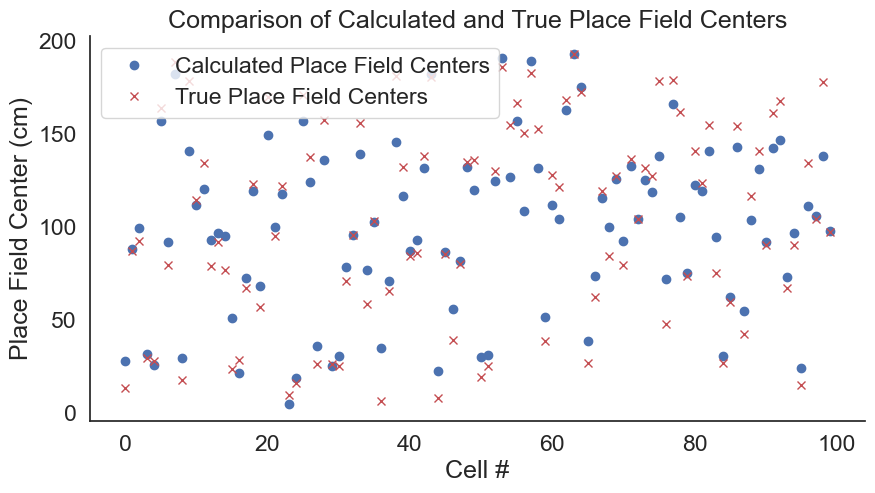

interactive(children=(IntSlider(value=0, description='i', max=99), Output()), _dom_classes=('widget-interact',…

<function __main__.plot_unit(i)>

In [74]:
# PLOTTING THE COMPARISON
def plot_comparison(calculated_centers, true_centers):
    plt.figure(figsize=(10, 5))
    plt.plot(calculated_centers, 'bo', label='Calculated Place Field Centers')
    plt.plot(true_centers, 'rx', label='True Place Field Centers')
    plt.xlabel('Cell #')
    plt.ylabel('Place Field Center (cm)')
    plt.legend()
    plt.title('Comparison of Calculated and True Place Field Centers')
    plt.show()

plot_comparison(calculated_centers, true_centers)

# FUNCTION TO PLOT INDIVIDUAL UNIT
def plot_unit(i):
    plt.figure(figsize=(10, 5))
    plt.plot(t, x, label='Track position')
    plt.plot(spikes[i], np.interp(spikes[i], t, x), 'r.', label='Spikes')
    plt.axvline(calculated_centers[i], color='b', linestyle='--', label='Calculated Center')
    plt.axvline(true_centers[i], color='r', linestyle='--', label='True Center')
    plt.xlabel('Time (s)')
    plt.ylabel('Position on track (cm)')
    plt.legend()
    plt.show()

interact(plot_unit, i=widgets.IntSlider(min=0, max=(n_cells - 1), value=0))

- The comparison plot provides a visual assessment of how well the calculated place field centers match the true place field centers.
- The interactive plot helps in examining the place field centers of individual cells in more detail.

## Exercise 2 - mutual information
---
A - Implement the mutual information formula discussed in the lesson, and apply it to the place cell data we simulated.

B - Adapt the simulation so that you can systematically vary 1) Peak firing rate, 2) place cell size 3) baseline noise. 
Study how mutual information vary with these parameters. Use both definition of mutual information above, and discuss the differences between them. Make some plots to show how the dependency goes.

## Exercise 3 - working with real data
---
Load the data from `linear_track_data.pickle`. It contains neural recordings from a mouse running on a linear track.
- `x` contains the position of the animal
- `t` contains the corresponding times, in seconds
- `spikes` contains a list of lists. Each list contains the timestamps of the spikes emitted by a neuron.

A - Visualiaze the position a s a function of time. Plot the spike of a selected cell in space.

B - Calculate the firing rate maps for all the cells, and plot them sorted by increasing peak positon.

C - Calculate the spatial information for each cell, and plot the distribution. Plot the firing rate maps of the 5 cells with lower spatial information, and the firing rate maps of the 5 cells with higher spatial information. Comment on the differences.